In [59]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint

def make_map():
    my_map = np.zeros((200,200))
    for i in range(12):
        x_range = randint(0,20)
        y_range = randint(0,20)
        x_start = randint(20,180)
        y_start = randint(20,180)
        
        my_map[x_start-x_range:x_start+x_range, y_start-y_range:y_start+y_range] = 1
    return my_map

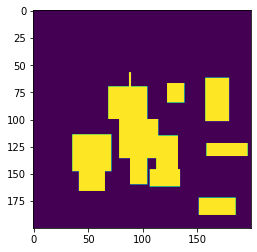

In [60]:
my_map = make_map()
plt.imshow(my_map)

## Test fns

### Original fns.

In [80]:
import numpy      as np
import matplotlib.pyplot as plt

def reconstruct_img(results, shape, img_width, subimg_spacing):
    width  = shape[0]
    height = shape[1]
    reconstructed = np.zeros((width,height))
    
    count = 0
    for i in range(0,width-img_width+1,subimg_spacing): 
        for j in range(0,height-img_width+1,subimg_spacing):  
            if results[count] > 0:
                reconstructed[i:i+img_width,j:j+img_width] = 1
            count += 1

    return reconstructed

In [77]:
def subimages(tissue, img_width, subimg_spacing, pca_components, n_bcc_lim):
    sub_images = []
    target = []
    
    (t_map,t_target,width,height) = tissue
    for i in range(0,width-img_width+1,subimg_spacing): 
        for j in range(0,height-img_width+1,subimg_spacing):  
            spectra = np.zeros((img_width,img_width,pca_components))
            
            for line in range(img_width):
                index = (i+line)*width + j
                spectra[:,line,:] = t_map[index:index+img_width,:]
            
            final_spectra = []
            # Change data structure from (40*40,PCA_COMPONENTS) to (PCA_COMPONENTS,40,40)
            for k in range(pca_components):
                final_spectra.append(np.transpose(spectra[:,:,k]))
            
            sub_images.append(final_spectra)


            bcc = t_target[i:i+img_width,j:j+img_width]
            #target.append(bcc)
            if np.count_nonzero(bcc) > n_bcc_lim:
                target.append(1)
            else:
                target.append(0)
                    
    return sub_images, target

In [ ]:
temp = my_map.reshape(40000,1)
t_map = np.zeros((40000,10))
for i in range(10):
    t_map[:,i] = np.squeeze(temp)

tissue = (t_map, my_map, 200, 200)

subimg, target = subimages(tissue,10,5,10,8)

In [ ]:
_, axs = plt.subplots(39,39, figsize=(10,10))
        
for i in range(39):
    for j in range(39):
        index = i*39 + j
        axs[i,j].imshow(np.squeeze(subimg[index][0]))

In [ ]:
rec = reconstruct_img(target,[200,200],10,5)
plt.imshow(rec)

### Subimage & reconstruct - center pixel

In [ ]:
def subimages_center(tissue, img_width, pca_components, padding=0):
    half_width = int(np.floor(img_width/2))
    new_tissues = []
    
    for (t_map,t_bcc) in tissue:
        if padding == 0: 
            # Zero-padding
            pad  = half_width
            padded_map = np.zeros((200+2*pad, 200+2*pad,pca_components))
            padded_map[pad:200+pad, pad:200+pad,:] = t_map
            
        if padding == -1:
            # No padding
            pad  = 0
            padded_map = t_map.copy()
        
        sub_images = []
        target = []
        for i in range(half_width, 200+2*pad - half_width): 
            for j in range(half_width, 200+2*pad - half_width):  
                #   In sub-image, center-pixel determines whether bcc or not:
                #   x x x x x
                #   x x x x x
                #   x x o x x
                #   x x x x x
                #   x x x x x
                
                # Take sub-image
                spectra = padded_map[i-half_width:i+half_width,j-half_width:j+half_width,:]
                
                # Change data structure from (40,40,PCA_COMPONENTS) to (PCA_COMPONENTS,40,40)
                final_spectra = []
                for k in range(pca_components):
                    final_spectra.append(np.transpose(spectra[:,:,k]))
                sub_images.append(final_spectra)

                # Look at center pixel
                if t_bcc[i-pad,j-pad] == 1:
                    target.append(1)
                else:
                    target.append(0)
        new_tissues.append((sub_images, target))
                    
    return new_tissues


def reconstruct_img_center(results, img_width, padding=0):
    if padding == 0:
        edge = 0
    if padding == -1:
        edge = int(np.floor(img_width/2))
        
    reconstructed = np.zeros((200,200))    
    reconstructed[edge:200-edge, edge:200-edge] = np.reshape(results,(200-2*edge,200-2*edge))

    return reconstructed

In [ ]:
t_map = np.zeros((200,200,10))
for i in range(10):
    t_map[:,:,i] = my_map

tissue = [(t_map, my_map)]

subimages = subimages_center(tissue, 5, 10, padding=-1)

In [ ]:
reconstructed = reconstruct_img_center(subimages[0][1],5,padding=-1)
plt.imshow(reconstructed)

# Fns

In [62]:
from random import randint
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

In [63]:
def make_peak(data, min_val, max_val, max_width):
    location  = randint(0,1023)
    amplitude = randint(min_val,max_val)
    width     = randint(0,max_width)

    for i in range (width):
        if location + i < 1024:
            data[location + i] = amplitude - 3*i
        if location - i >= 0:
            data[location - i] = amplitude - 3*i

    return data

def add_noise(bcc_map, healthy, bcc, mean, std):
    img_spectra = np.zeros((200,200,1024))

    for i in range(200):
        for j in range(200):
            if bcc_map[i,j] == 0:
                img_spectra[i,j] = healthy + np.random.normal(mean,std,1024)
            else:
                img_spectra[i,j] = bcc     + np.random.normal(mean,std,1024)

    return img_spectra

def add_baseline(data, max_amplitude):
    x    = np.linspace(0,1023,4)
    x_bl = np.linspace(0,1023,1024)

    coeff = [randint(0,max_amplitude),randint(0,max_amplitude),randint(0,max_amplitude),randint(0,max_amplitude)]
    f = interp1d(x,coeff,kind='cubic')
    baseline = f(x_bl)

    data += baseline
    return data

def my_pca(bcc_map, img_spectra, pca_components):
    ## Train PCA only on relevant BCC data
    pca_training_data = np.zeros((1000,1024))
    transformed       = np.zeros((200,200,pca_components))
    count = 0

    for i in range(200):
        for j in range(200):
            if count < 1000:
                if bcc_map[i,j] == 1:
                    pca_training_data[count,:] = img_spectra[i,j,:]
                    count += 1

    ### Perform PCA dimensionality reduction ###
    norm_data = normalize(pca_training_data)
    pca = PCA(n_components=pca_components)
    pca.fit(norm_data)

    for i in range(200):
        transformed[i,:,:] = pca.transform(img_spectra[i,:,:])

    return transformed

In [64]:
## Imports and adapted functions
from CNN2D                import CNN2D, train_model, test_model, analyse_train_test
from gniadecka_functions  import first_derivative_bl_removal
from subimages            import reconstruct_img
import numpy as np

# Test script

In [65]:
LEARNING_RATE  = 0.01
EPOCHS        = 5000
DROPOUT_RATE  = 0.1
TRAIN_CUTOFF  = 1200
SUBIMG_SPACING= 5
IMG_WIDTH     = 10
PCA_COMPONENTS= 10
N_BCC_LIM     = 20
BL_AMPLITUDE  = 50
PEAK_HEIGHTS  = [30,60]
PEAK_WIDTHS   = [20,10]
NOISE_STD     = 5

In [66]:
parameters = {
    'LEARNING_RATE' : 0.01,
    'EPOCHS'        : 5000,
    'DROPOUT_RATE'  : 0.1,
    'TRAIN_CUTOFF'  : 1200,
    'SUBIMG_SPACING': 5,
    'IMG_WIDTH'     : 10,
    'PCA_COMPONENTS': 10,
    'N_BCC_LIM'     : 20,
    'BL_AMPLITUDE'  : 50,
    'PEAK_HEIGHTS'  : [30,60],
    'PEAK_WIDTHS'   : [20,10],
    'NOISE_STD'     : 3
}

In [67]:
## 1. Create "ideal" spectra for healthy vs. BCC
healthy = np.zeros((1024))
bcc     = np.zeros((1024))

for i in range(5): # 5 big peaks
    healthy = make_peak(healthy, PEAK_HEIGHTS[0], PEAK_HEIGHTS[1], PEAK_WIDTHS[0])
    bcc     = make_peak(bcc    , PEAK_HEIGHTS[0], PEAK_HEIGHTS[1], PEAK_WIDTHS[0])
for i in range(10): # 10 small peaks
    healthy = make_peak(healthy, 1, PEAK_HEIGHTS[0], PEAK_WIDTHS[1])
    bcc     = make_peak(bcc    , 1, PEAK_HEIGHTS[0], PEAK_WIDTHS[1])

# Remove negative elements (make_peak can return negative values)
healthy = [0 if i < 0 else i for i in healthy]
bcc     = [0 if i < 0 else i for i in bcc]

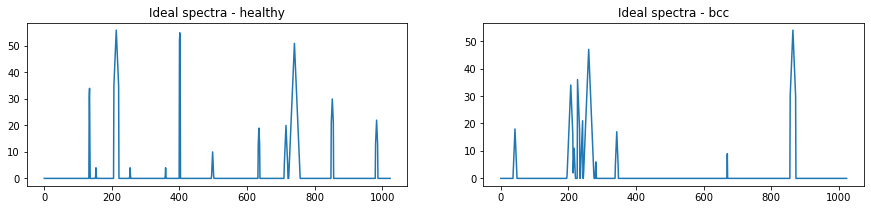

In [68]:
_, axs = plt.subplots(1,2, figsize=(15,3))
axs[0].plot(healthy)
axs[0].title.set_text('Ideal spectra - healthy')
axs[1].plot(bcc)
axs[1].title.set_text('Ideal spectra - bcc')

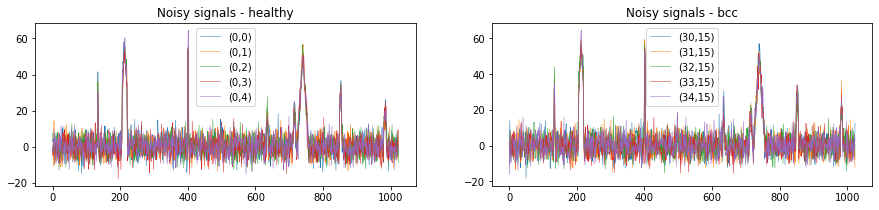

In [70]:
###############################################
## 2. Add 0-mean Gaussian noise
mean = 0
img_spectra = add_noise(my_map, healthy,bcc,mean,NOISE_STD)

_, axs = plt.subplots(1,2, figsize=(15,3))
axs[0].plot(np.transpose(img_spectra[0:5,0,:]), linewidth=0.5)
axs[0].title.set_text('Noisy signals - healthy')
axs[0].legend(['(0,0)','(0,1)','(0,2)','(0,3)','(0,4)'])
axs[1].plot(np.transpose(img_spectra[30:35,15,:]), linewidth=0.5)
axs[1].title.set_text('Noisy signals - bcc')
axs[1].legend(['(30,15)','(31,15)','(32,15)','(33,15)','(34,15)'])

In [71]:
###############################################
img_spectra_bl = img_spectra.copy()
## 3. Add and remove baseline
for i in range(200):
    for j in range(200):
        img_spectra_bl[i,j]  = add_baseline(img_spectra[i,j],BL_AMPLITUDE)
        x = np.linspace(0,1023,1024)
        [img_spectra[i,j],_] = first_derivative_bl_removal(x,img_spectra_bl[i,j])

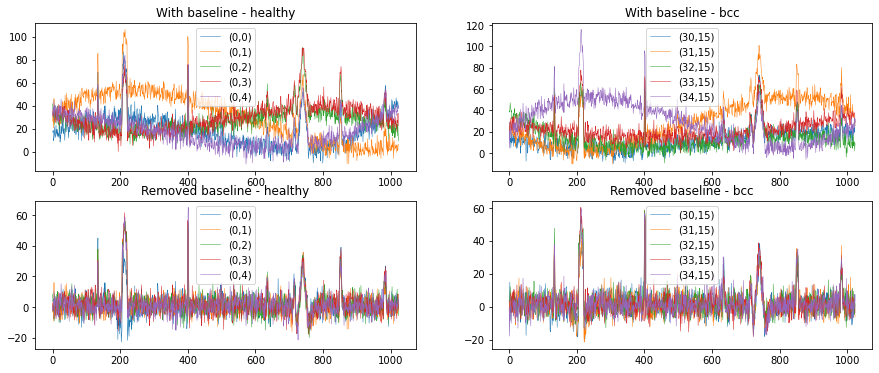

In [72]:
_, axs = plt.subplots(2,2, figsize=(15,6))
axs[0,0].plot(np.transpose(img_spectra_bl[0:5,0,:]), linewidth=0.5)
axs[0,0].title.set_text('With baseline - healthy')
axs[0,0].legend(['(0,0)','(0,1)','(0,2)','(0,3)','(0,4)'])

axs[0,1].plot(np.transpose(img_spectra_bl[30:35,15,:]), linewidth=0.5)
axs[0,1].title.set_text('With baseline - bcc')
axs[0,1].legend(['(30,15)','(31,15)','(32,15)','(33,15)','(34,15)'])

axs[1,0].plot(np.transpose(img_spectra[0:5,0,:]), linewidth=0.5)
axs[1,0].title.set_text('Removed baseline - healthy')
axs[1,0].legend(['(0,0)','(0,1)','(0,2)','(0,3)','(0,4)'])

axs[1,1].plot(np.transpose(img_spectra[30:35,15,:]), linewidth=0.5)
axs[1,1].title.set_text('Removed baseline - bcc')
axs[1,1].legend(['(30,15)','(31,15)','(32,15)','(33,15)','(34,15)'])
#plt.savefig('signals.png')

In [74]:
###############################################
## 4. Perform PCA
pca_reduced = my_pca(my_map,img_spectra,PCA_COMPONENTS)

In [78]:
## 5. Get sub-images
t_map = pca_reduced.reshape(40000,10) 
sub_images, target = subimages((t_map, my_map, 200, 200), IMG_WIDTH, SUBIMG_SPACING, PCA_COMPONENTS, N_BCC_LIM)

100%|██████████| 5000/5000 [01:33<00:00, 53.72it/s]


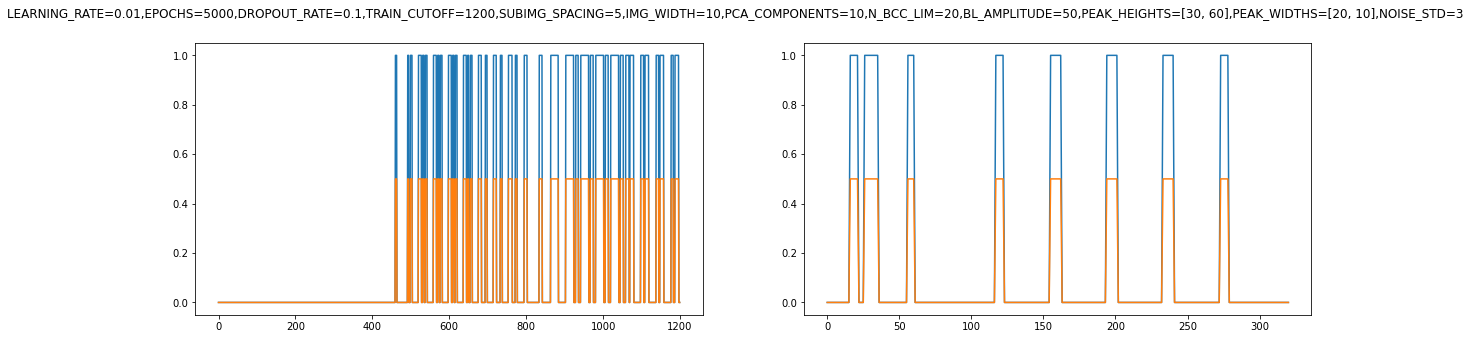

In [81]:
 ## 6. CNN
model = CNN2D(IMG_WIDTH,PCA_COMPONENTS,DROPOUT_RATE)
train_model(model, sub_images[:TRAIN_CUTOFF], target[:TRAIN_CUTOFF], LEARNING_RATE, EPOCHS, IMG_WIDTH, PCA_COMPONENTS)

approximation_train = test_model(model, sub_images[:TRAIN_CUTOFF], IMG_WIDTH, PCA_COMPONENTS)
approximation_test  = test_model(model, sub_images[TRAIN_CUTOFF:], IMG_WIDTH, PCA_COMPONENTS)

train_res, test_res, _ = analyse_train_test(approximation_train, approximation_test, target, TRAIN_CUTOFF, parameters, plot=1, text=1)
total_res = train_res
for i in test_res:
    total_res.append(i)
    
reconstructed = reconstruct_img(total_res, [200,200], IMG_WIDTH, SUBIMG_SPACING)

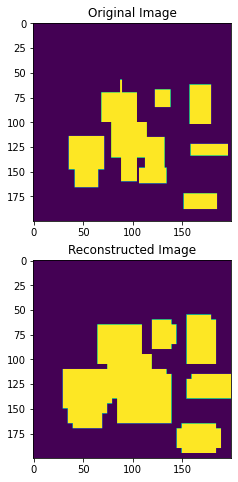

In [83]:
_, axs = plt.subplots(2,1, figsize=(4,8))
axs[0].imshow(my_map)
axs[0].title.set_text('Original Image')

axs[1].imshow(reconstructed)
axs[1].title.set_text('Reconstructed Image')

# Real data

In [ ]:
from import_data import import_data
from CNN2D       import CNN2D, train_model, test_model, get_error
from pca         import my_pca
from subimages   import subimages, reconstruct_img

# Parameters
PCA_COMPONENTS  = 20
IMG_WIDTH       = 20
SUBIMG_SPACING  = 10
N_BCC_LIM       = 15
LEARNING_RATE   = 0.001
EPOCHS          = 10000
DROPOUT_RATE    = 0.1

For now load data without bl, later include baseline removal 
Also just using data with bcc map 

In [ ]:
data = import_data() # list of touples: (t_map,t_target,width,height), t_map with dimensions (width*height, 1024)

In [ ]:
data_pca = my_pca(data, PCA_COMPONENTS)
new_tissues = subimages(data_pca, IMG_WIDTH, SUBIMG_SPACING, PCA_COMPONENTS, N_BCC_LIM)

In [ ]:
model = CNN2D(IMG_WIDTH,PCA_COMPONENTS,DROPOUT_RATE)

for i in range(5):
    model = train_model(model, new_tissues[i][0], new_tissues[i][1], LEARNING_RATE, EPOCHS, IMG_WIDTH, PCA_COMPONENTS)

In [ ]:
results = []
for i in range(9):
    approximation = test_model(model, new_tissues[i][0], IMG_WIDTH, PCA_COMPONENTS)
    _, result = get_error(approximation, new_tissues[i][1])
    reconstructed = reconstruct_img(result, [200,200], IMG_WIDTH, SUBIMG_SPACING)
    results.append((data[i][1],reconstructed))

In [ ]:
import matplotlib.pyplot as plt
_, axs = plt.subplots(9,2, figsize=(10,50))
        
for i in range(9):
    axs[i,0].imshow(results[i][0])
    axs[i,1].imshow(results[i][1])